Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Строится модель для такого предсказания.

Для исследования и построения модели предсказания необходимо проанализировать полученные данные и выявить закономерности, оказывающие влияние на количество заказов.

## Загрузка и подготовка данных

In [1]:
import warnings
#Импорты сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Импорты необходимых модулей
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score)
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('Taxi.csv')

In [3]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data.set_index('datetime', inplace=True)

In [5]:
print(f'Индексы расположены в хронологическом порядке: {data.index.is_monotonic}')

Индексы расположены в хронологическом порядке: True


In [6]:
data = data.resample('1H').sum()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ данных

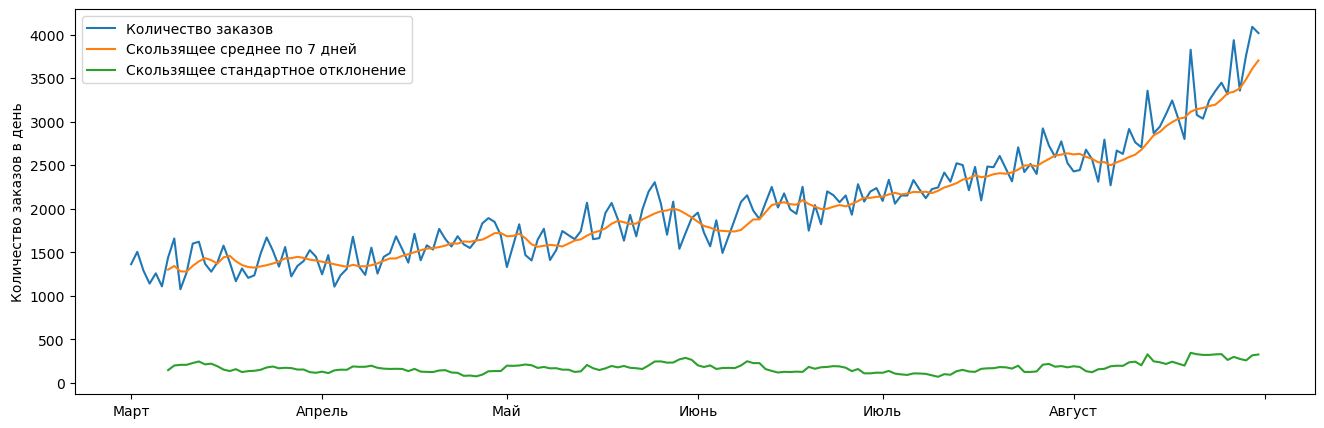

In [8]:
data_daily = data.resample('1D').sum()
data_daily['rolling'] = data_daily.rolling(7).mean()
data_daily['std'] = data_daily['num_orders'].rolling(7).std()
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(data_daily, label=['Количество заказов', 'Скользящее среднее по 7 дней', 'Скользящее стандартное отклонение'])
ax.legend()
ax.set_xticklabels(['Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август'])
ax.set_ylabel('Количество заказов в день');

**На графике заметен общий тренд к увеличению общего количества заказов в день (прмерно с полутора тысяч заказов в день в марте до почти четырёх тысяч к концу августа) при относительно стабильном разбросе в пределах 350-400 заказов в день.**

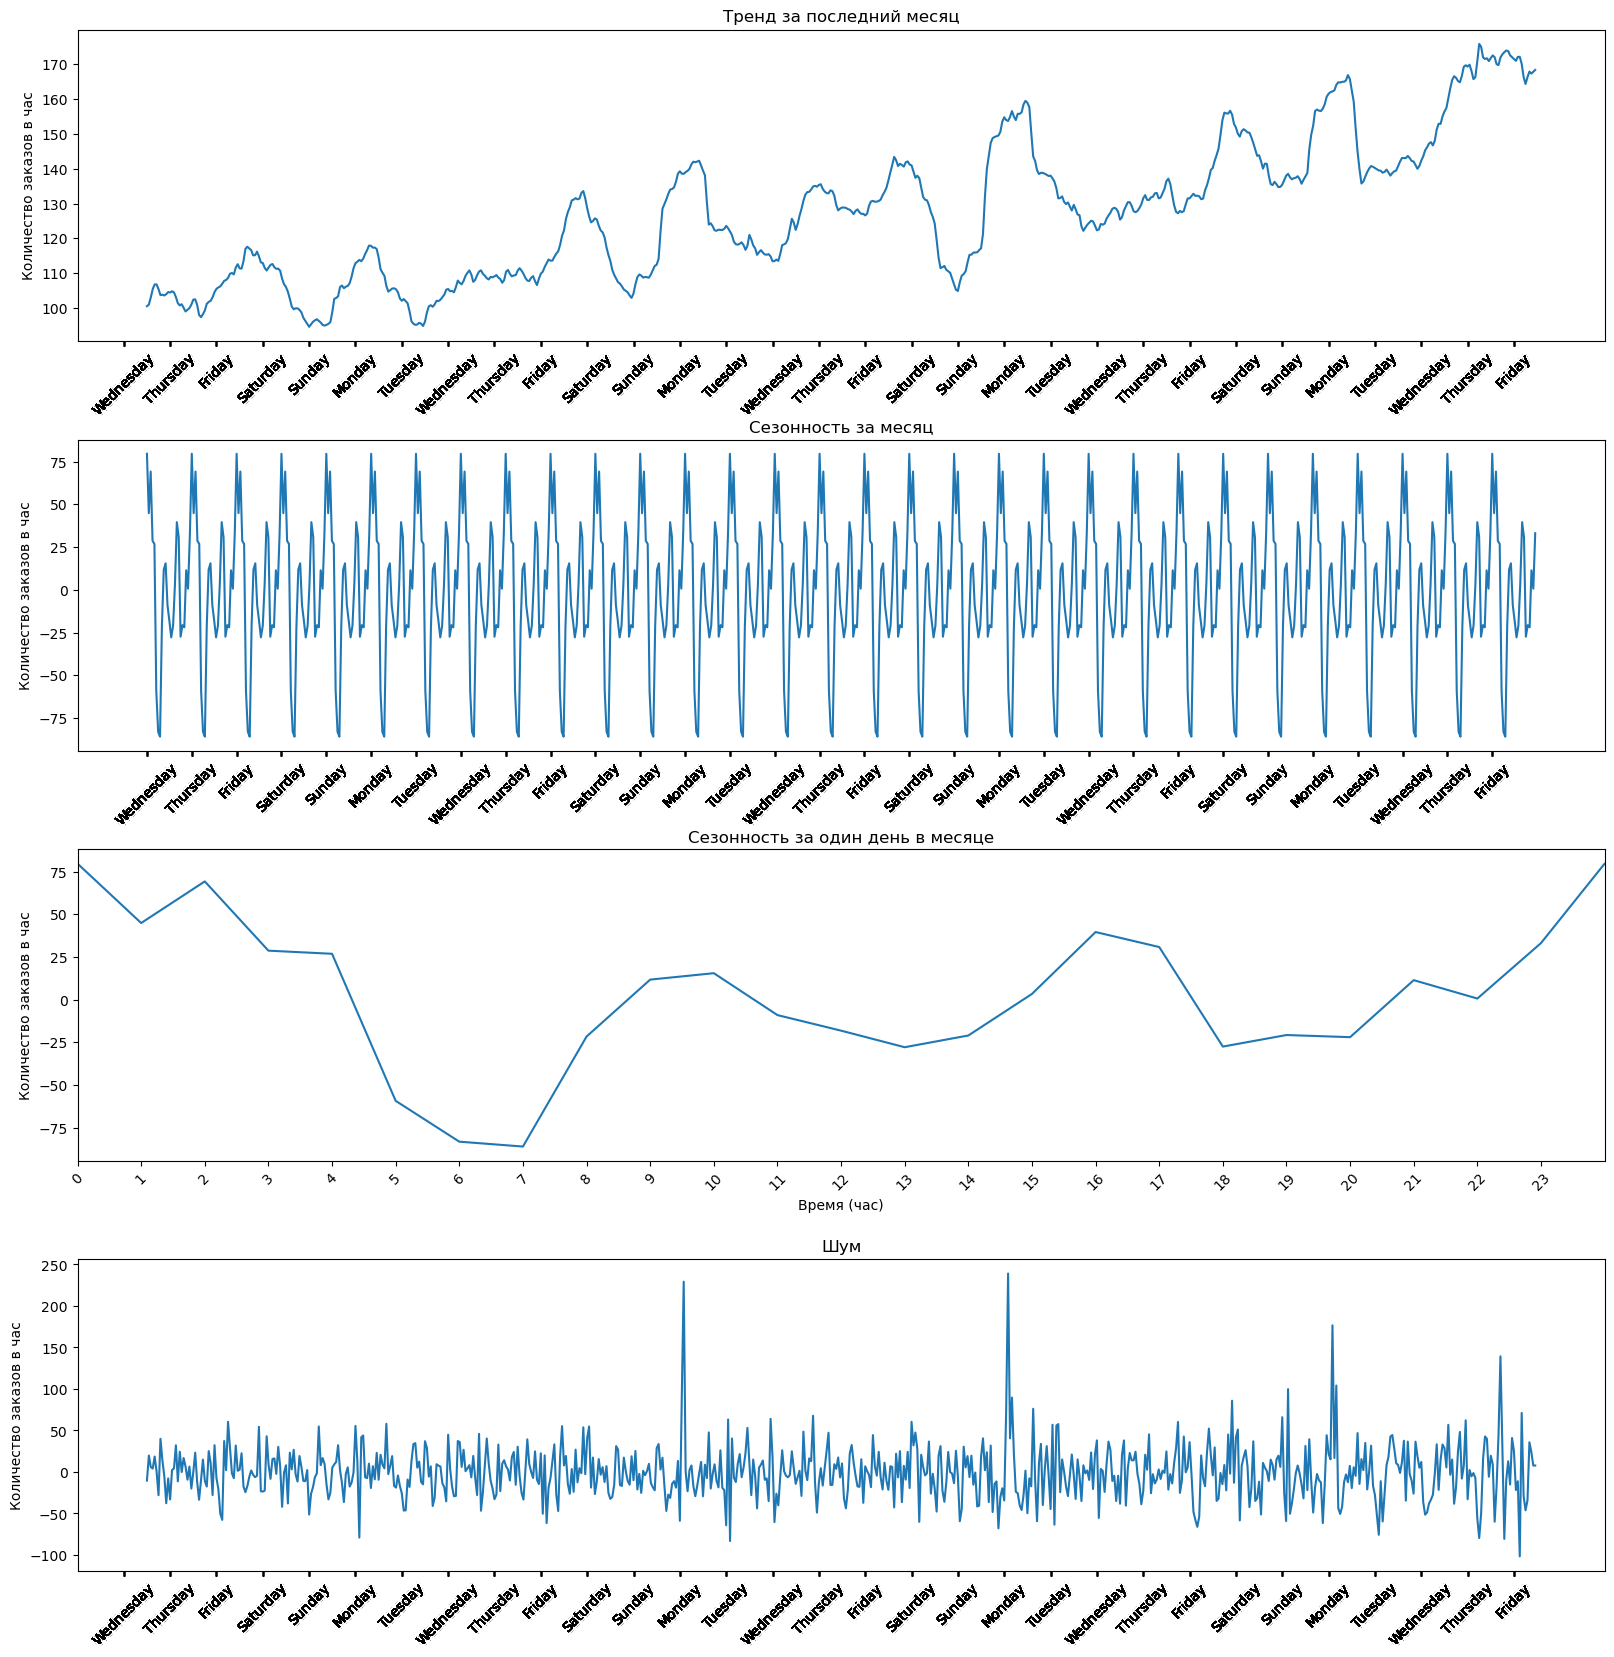

In [9]:
data_last_month = data['2018-08-01':'2018-08-31']
decomposed_last_month = seasonal_decompose(data_last_month)
dates, day_of_week = data_last_month.index.date, data_last_month.index.day_name()
hours = data_last_month.index[0:24].hour
fig, ax=plt.subplots(4, 1, figsize=(16,16))
fig.tight_layout(h_pad=5)
ax[0].plot(decomposed_last_month.trend)
ax[1].plot(decomposed_last_month.seasonal)
ax[2].plot(decomposed_last_month.seasonal)
ax[3].plot(decomposed_last_month.resid)
ax[0].set_ylabel('Количество заказов в час')
ax[0].set_title('Тренд за последний месяц')
ax[0].set_xticks(ticks=dates, labels=day_of_week, rotation=45)
ax[1].set_ylabel('Количество заказов в час')
ax[1].set_title('Сезонность за месяц')
ax[1].set_xticks(ticks=dates, labels=day_of_week, rotation=45)
ax[2].set_ylabel('Количество заказов в час')
ax[2].set_xlabel('Время (час)')
ax[2].set_title('Сезонность за один день в месяце')
ax[2].set_xlim(data_last_month.index[0], data_last_month.index[24])
ax[2].set_xticks(ticks=data_last_month.index[0:24], labels=hours, rotation=45)
ax[3].set_ylabel('Количество заказов в час')
ax[3].set_title('Шум')
ax[3].set_xticks(ticks=dates, labels=day_of_week, rotation=45);

**На графиках за август также замечен общий тренд к увеличению числа заказов в час в пределах месяца (100 - 110 заказов в час в начале месяца и почти 170 к концу). При этом отчётливо прослеживается большее число заказов по пятницам и понедельникам, спад спроса по остальным будням и самое малое количество заказов по воскресеньям.**  

**Прослеживается ежедневная сезонность с колебаниями +/- 75 заказов в зависимости от времени суток: пиковая нагрузка приходится на полночь, а самые спокойные часы - около 7 утра.**  

**На графике шумов видны аномальные всплески заказов в ночи на понедельники (до 250 заказов в час)**

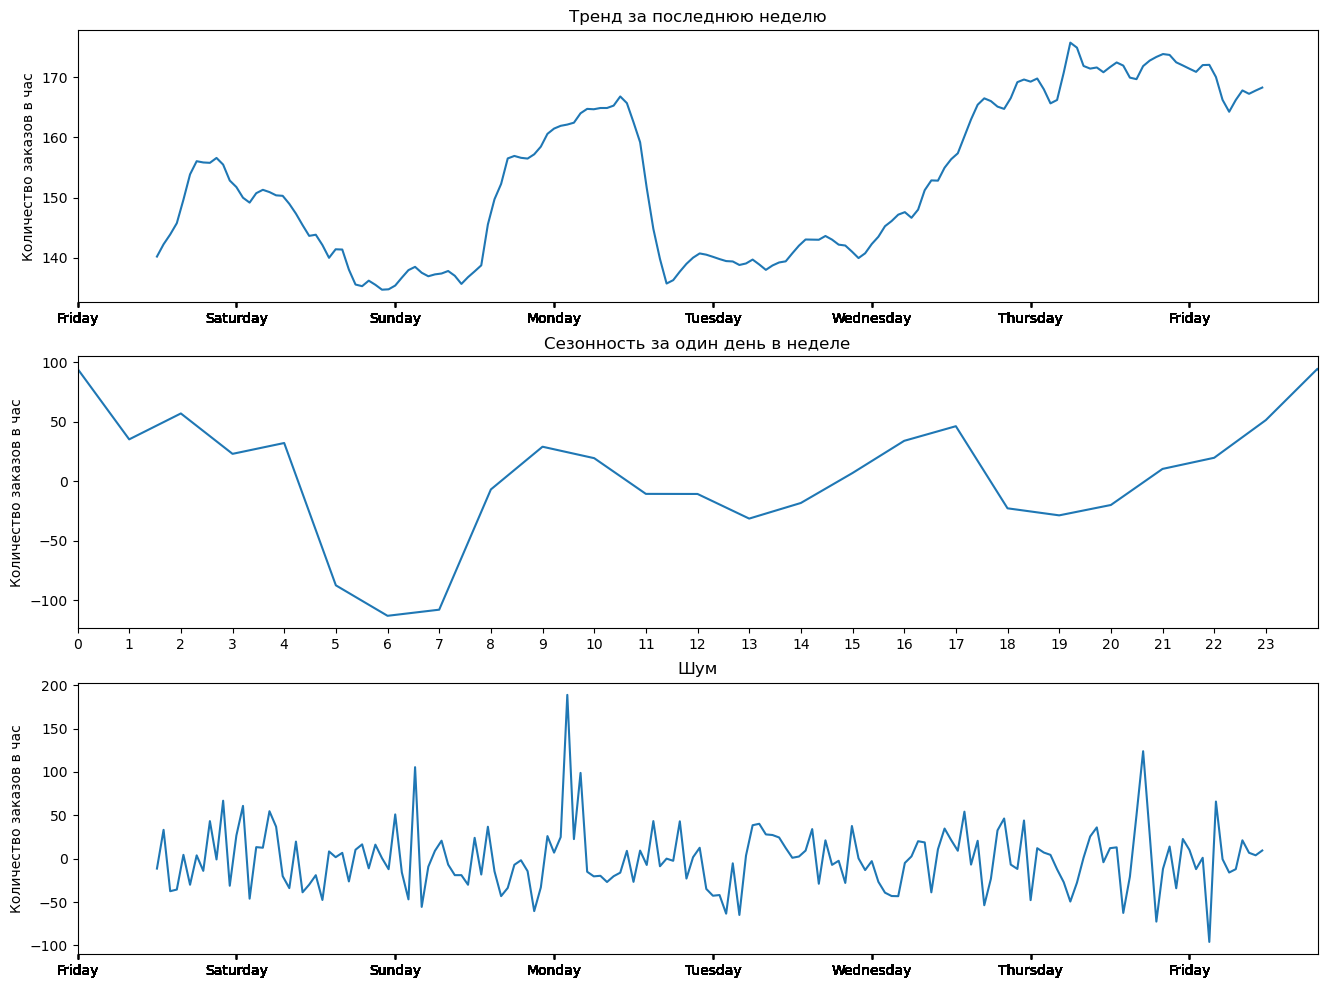

In [10]:
data_last_week = data['2018-08-24':]
decomposed_last_week = seasonal_decompose(data_last_week)
fig, ax=plt.subplots(3, 1, figsize=(16,12))
ax[0].plot(decomposed_last_week.trend)
ax[1].plot(decomposed_last_week. seasonal)
ax[2].plot(decomposed_last_week.resid)
ax[0].set_ylabel('Количество заказов в час')
ax[0].set_title('Тренд за последнюю неделю')
ax[0].set_xticks(ticks=data_last_week.index.date, labels=data_last_week.index.day_name())
ax[1].set_ylabel('Количество заказов в час')
ax[1].set_title('Сезонность за последнюю неделю')
ax[1].set_title('Сезонность за один день в неделе')
ax[1].set_xlim(data_last_week.index[0], data_last_week.index[24])
ax[1].set_xticks(ticks=data_last_week.index[0:24], labels=hours)
ax[2].set_ylabel('Количество заказов в час')
ax[2].set_title('Шум')
ax[2].set_xticks(ticks=data_last_week.index.date, labels=data_last_week.index.day_name());

**Графики за последнюю неделю подтверждают выводы по графикам за месяц, тренд и сезонность совпадают**

## Обучение моделей

На основании анализа, делаем вывод о признаках, влияющих на количество заказов:
 - Час суток
 - День недели

In [11]:
#Проверим модель на адекватность
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

predictions_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE при предсказании медианой:", mean_squared_error(predictions_median, test) ** 0.5)
predictions_shift = test.shift(fill_value=float(train.iloc[-1]))
print("RMSE при предсказании предыдущим значением", mean_squared_error(predictions_shift, test)**0.5)

RMSE при предсказании медианой: 87.15277582981295
RMSE при предсказании предыдущим значением 58.856486242815066


In [12]:
#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data_modified = data.copy()
    data_modified['hour'] = data.index.hour
    data_modified['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_modified['lag_{}'.format(lag)] = data_modified['num_orders'].shift(lag)

    data_modified['rolling_mean'] = data_modified['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_modified

In [13]:
data_modified = make_features(data, 1, 24)
data_modified

train, test = train_test_split(data_modified, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [14]:
model = LinearRegression()
splitter = TimeSeriesSplit(n_splits=5) 
score = cross_val_score(model, features_train, target_train, cv=splitter, scoring='neg_root_mean_squared_error') 
print(f'RMSE тренировочной выборки для модели Линейной регрессии равна {-score.mean()}')

RMSE тренировочной выборки для модели Линейной регрессии равна 31.79374982444761


>Ниже закоментил, ввиду неприлично долгого времени подбора параметров, выдачу сохранил в текстовой ячейке

In [15]:
#%%time
#final_score = -1000
#best_iteration_qty = 0
#best_depth = 0
#for iterations in [50, 100, 200, 500, 1000]:
#    for depth in range(1, 23, 3):
#        model = CatBoostRegressor(depth=depth, iterations=iterations, verbose=False)
#        score = cross_val_score(model, features_train, target_train, cv=splitter, scoring='neg_root_mean_squared_error')
#        result = -score.mean()
#        if result > final_score:
#            final_score = result
#            best_iteration_qty = iterations
#            best_depth = depth
#print(f' Лучшая RMSE, {-final_score}, модели CatBoost достигается при глубине дерева {best_depth} \
#и количеству повторов {best_iteration_qty}')

Лучшая RMSE, 25.080536374398086, модели CatBoost достигается при глубине дерева 6 и количеству повторов 100
Wall time: 57min 40s

In [16]:
%%time
final_score = -1000
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeRegressor(max_depth=depth)
    score = cross_val_score(model, features_train, target_train, cv=splitter, scoring='neg_root_mean_squared_error')
    result = score.mean()
    if result > final_score:
        final_score = result
        best_depth = depth
print(f' Лучшая RMSE, {-final_score}, модели Decision Tree Regressor достигается при глубине дерева {best_depth}')

 Лучшая RMSE, 29.328011753319362, модели Decision Tree Regressor достигается при глубине дерева 8
Wall time: 629 ms


In [42]:
model = CatBoostRegressor(iterations=100, depth=6, verbose=False)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
RMSE = mean_squared_error(target_test, predictions) ** 0.5
print(f'RMSE тестовой выборки для лучшей модели CatBoost равна {RMSE}')

RMSE тестовой выборки для лучшей модели CatBoost равна 43.62000931716662


Text(0.5, 1.0, 'Фактические значения - Предсказания')

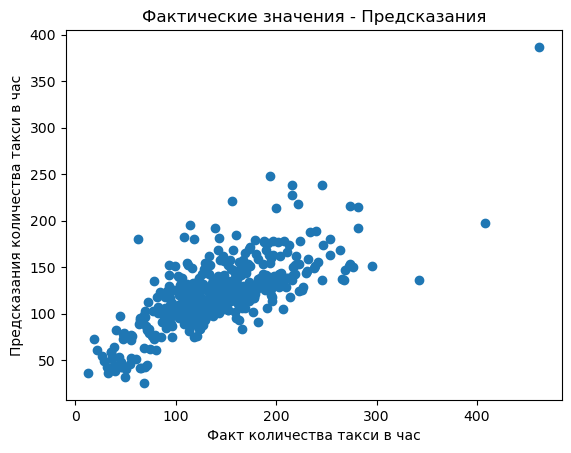

In [46]:
plt.scatter(target_test, predictions)
plt.xlabel('Факт количества такси в час')
plt.ylabel('Предсказания количества такси в час')
plt.title('Фактические значения - Предсказания');

Text(0.5, 1.0, 'Распределение разницы между фактическим количеством заказов и предсказанным')

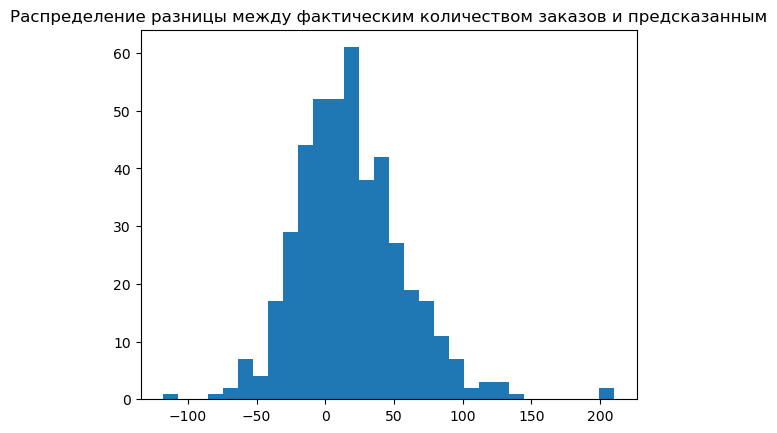

In [56]:
plt.hist(target_test-predictions, bins=30);
plt.title('Распределение разницы между фактическим количеством заказов и предсказанным')

## Выводы

Было проведено исследование на исторических данных о заказах такси в аэропортах.  
В ходе исследования были выявлены следующие закономерности:  
- Общее увеличение количества заказов такси: более, чем в два раза за пол года.
- Повышенный спрос с вечера пятницы до раннего утра субботы и с ночи воскресенья до обеда понедельника. 
- Пониженный спрос по воскресеньям
- Повышенный спрос в полночь
- Пониженный спрос между 6 и 7 утра.

На основании анализа были построенны и обучены несколько моделей (Linear Regression, CatBoost и DecisionTreeRegressor), по результатам кросс-валидации на тренировочной выборке, лучшая метрика RMSE выявлена у модели CatBoost при глубине дерева 15 и количеству итераций 1000. Модель удовлетворительно показала себя на тестовой выборке с метриков RMSE 

>Я же правильно понимаю, что ни одна из моделей этот общий тренд к увеличению количества заказов не воспринимает и не учитывает?  
Естественно, как и повышение спроса в предпраздничные вечера и после праздников. Для таких случаев код пишется вручную исходя их наших предположений о повышении спроса или используются данные за больший период?